In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('/kaggle/input/phishing-email-dataset/CEAS_08.csv')
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64

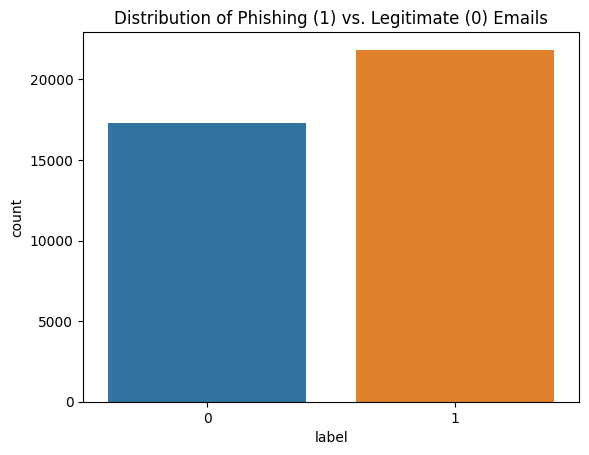

In [3]:
# Distribution of the label column
sns.countplot(x='label', data=df)
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.show()

In [4]:
# Analyzing the date column
df['date'] = pd.to_datetime(df['date'], format='%a, %d %b %Y %H:%M:%S %z', errors='coerce', utc=True)
print(df['date'].dtype)

datetime64[ns, UTC]


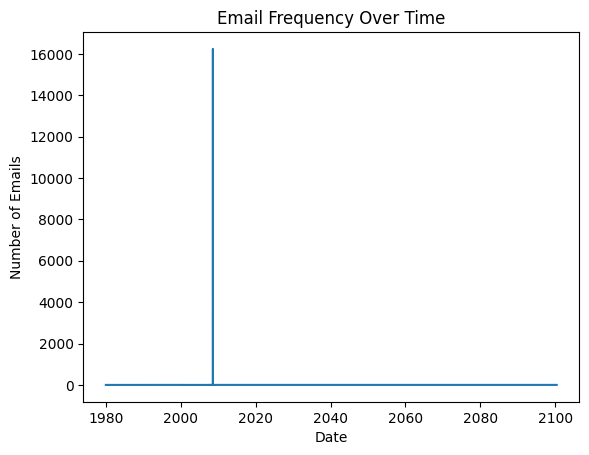

In [5]:
# Creating separate columns for Date and Time
df['Date'] = df['date'].dt.date
df['Time'] = df['date'].dt.time

# Handling any remaining NaT values (if any)
df = df.dropna(subset=['date'])

# Plotting the distribution of emails over time
df['Date'].value_counts().sort_index().plot()
plt.title('Email Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Emails')
plt.show()

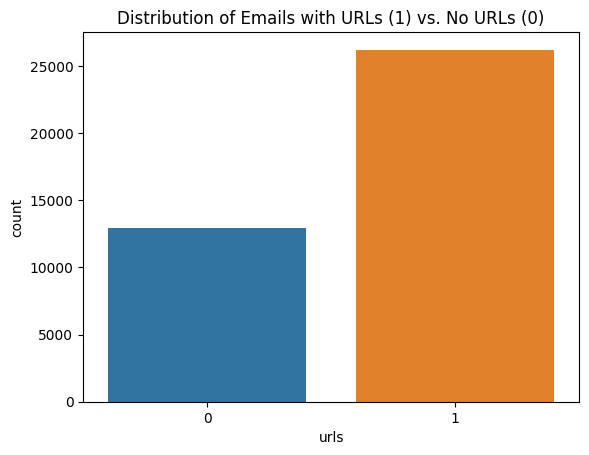

In [6]:
# Distribution of URLs in the emails
sns.countplot(x='urls', data=df)
plt.title('Distribution of Emails with URLs (1) vs. No URLs (0)')
plt.show()

Accuracy: 0.6131545777472213
Confusion Matrix:
[[2638 1701]
 [1675 2713]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61      4339
         1.0       0.61      0.62      0.62      4388

    accuracy                           0.61      8727
   macro avg       0.61      0.61      0.61      8727
weighted avg       0.61      0.61      0.61      8727



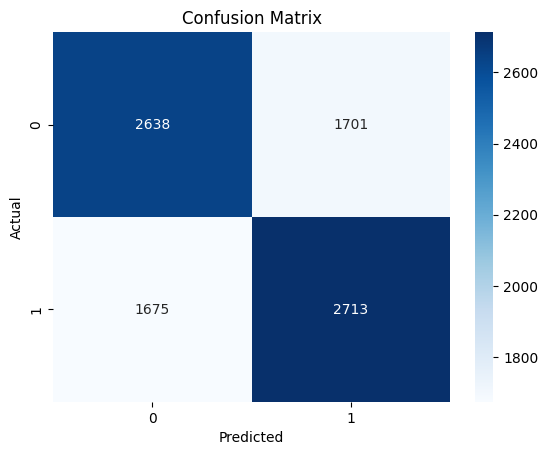

In [7]:
# Preprocessing the body text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Transform the body text to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['body'])

# Combining other features with TF-IDF features
features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
features['urls'] = df['urls']
features['label'] = df['label']

# Ensure there are no missing values in the features
features = features.dropna()

# Splitting the dataset into features and target
X = features.drop('label', axis=1)
y = features['label']

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Building a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Visualizing the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()